In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
np.set_printoptions(precision = 3, suppress = True)

## 1D first order equation $\frac{d\Psi}{dx}+(x+\frac{1+3x^2}{1+x+x^3})\Psi = x^3+2x-x^2 \frac{1+3x^2}{1+x+x^3}$ with IC $\Psi(0)=1$

In [214]:
H = 10

model3 = keras.Sequential([
    layers.Dense(units = H, activation = 'sigmoid', input_shape = (1,)),
    layers.Dense(units = 1, activation = 'linear', use_bias = False)
])

model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                20        
                                                                 
 dense_21 (Dense)            (None, 1)                 10        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [215]:
a = 0
b = 1
N = 18
h = (b - a)/(N + 1)

#domain discretization to be used as input data
x = []
for i in range(N + 2):
    x.append(a + i*h)
input_data = np.array(x)
input_data = input_data.reshape(N+2,1)

In [216]:
def trainStep(x,opt):
    
    # Outer gradient for model parameters
    with tf.GradientTape() as tape:
        
        # Inner gradient for first derivative of N wrt x
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            
            # Inner inner gradient for second derivative of N wrt x
            with tf.GradientTape() as tape2:
                tape2.watch(x)
            
                N = model3([x])
            
            Nx = tape2.gradient(N, x)
        Nxx = tape1.gradient(Nx, x)
        
        # Plug trial solution into ODE:
        # eqn = (x*Nx + N + (x+(1+3*x**2)/(1+x+x**3))*(1+x*N)-
        #        x**3-2*x-x**2*(1+3*x**2)/(1+x+x**3))
        eqn = Nx + (x+(1+3*x**2)/(1+x+x**3)) * N - x**3-2*x-x**2*(1+3*x**2)/(1+x+x**3)
        
        loss = tf.reduce_sum(tf.square(eqn)) + (tf.squeeze(N[0])-1)**2
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model3.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model3.trainable_variables))
    
    
    return loss

In [217]:
def PINNtrain(x, epochs):
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    opt = keras.optimizers.Adam(lr)
    epoch_loss = np.zeros(epochs)
    
    # Main training loop
    for i in range(epochs):
        
        PDEloss = trainStep(x,opt)
        epoch_loss[i] = PDEloss
        
        if (np.mod(i, 100)==0):
          print("PDE loss in {}th epoch: {: 6.4f}.".format(i, PDEloss.numpy()))
    
    return epoch_loss

In [218]:
epochs = 10000
loss = PINNtrain(tf.convert_to_tensor(input_data, dtype = float),epochs)
loss

PDE loss in 0th epoch:  53.7718.
PDE loss in 100th epoch:  3.9322.
PDE loss in 200th epoch:  0.7587.
PDE loss in 300th epoch:  0.2246.
PDE loss in 400th epoch:  0.0759.
PDE loss in 500th epoch:  0.0261.
PDE loss in 600th epoch:  0.0116.
PDE loss in 700th epoch:  0.0059.
PDE loss in 800th epoch:  0.0035.
PDE loss in 900th epoch:  0.0024.
PDE loss in 1000th epoch:  0.0020.
PDE loss in 1100th epoch:  0.0020.
PDE loss in 1200th epoch:  0.0017.
PDE loss in 1300th epoch:  0.0016.
PDE loss in 1400th epoch:  0.0016.
PDE loss in 1500th epoch:  0.0015.
PDE loss in 1600th epoch:  0.0014.
PDE loss in 1700th epoch:  0.0017.
PDE loss in 1800th epoch:  0.0013.
PDE loss in 1900th epoch:  0.0013.
PDE loss in 2000th epoch:  0.0367.
PDE loss in 2100th epoch:  0.0012.
PDE loss in 2200th epoch:  0.0012.
PDE loss in 2300th epoch:  0.0011.
PDE loss in 2400th epoch:  0.0241.
PDE loss in 2500th epoch:  0.0011.
PDE loss in 2600th epoch:  0.0011.
PDE loss in 2700th epoch:  0.0011.
PDE loss in 2800th epoch:  0.00

KeyboardInterrupt: 

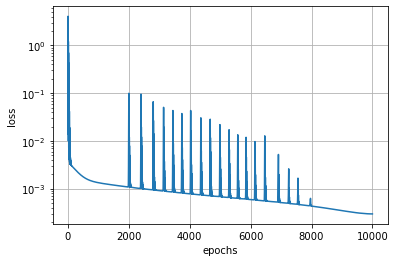

<Figure size 432x288 with 0 Axes>

In [127]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()
plt.savefig('loss.png')

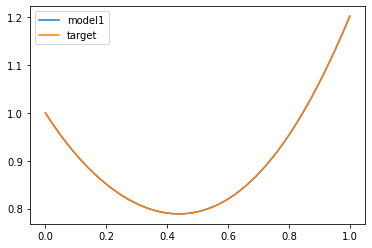

In [130]:
x = np.linspace(0,1,10)
discrete = np.linspace(0,1,100)
target = []

for i in range(100): 
    x_i = discrete[i]
    target.append((np.exp(-x_i**2/2))/(1+x_i+x_i**3) + x_i**2) 
    
#plt.plot(discrete,1 + discrete*model3([discrete]).numpy().T[0], label = 'model1')
plt.plot(discrete, model3([discrete]).numpy().T[0], label = 'model1')
plt.plot(discrete,target, label = 'target')
plt.legend(loc =  'upper left')

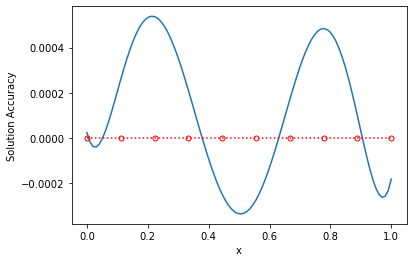

In [132]:
plt.plot(discrete,target-(model3([discrete]).numpy().T[0]))
plt.plot(discrete,[0]*100, ':r')
plt.plot(x,[0]*10, 'o', color = 'red', mfc = 'none', markersize = 5)
plt.ylabel('Solution Accuracy')
plt.xlabel('x')
plt.show()

## 1D second order equation $-\frac{d}{dx}\left((1+\frac{1}{4}\sin {2\pi x})\frac{d\Psi}{dx}\right) + \nu \Psi=- 2\pi^2 \cos{2\pi x}\cos{4\pi x} + 16\pi^2(1+\frac{1}{4}\sin {2\pi x})\sin{4\pi x} + \nu \sin{4\pi x}$ with periodic BC $\Psi(0)=\Psi(1)$, $\Psi'(0)=\Psi'(1)$

## Exact solution: $\Psi(x) = \sin{4\pi x}$

In [95]:
nu = 5

In [96]:
H = 10

model4 = keras.Sequential([
    layers.Dense(units = H, activation = 'sigmoid', input_shape = (1,)),
    layers.Dense(units = 1, activation = 'linear', use_bias = False)
])

model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                20        
                                                                 
 dense_25 (Dense)            (None, 1)                 10        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [97]:
a = 0
b = 1
N = 18
h = (b - a)/(N + 1)

#domain discretization to be used as input data
x = []
for i in range(N + 2):
    x.append(a + i*h)
input_data = np.array(x)
input_data = input_data.reshape(N+2,1)

In [98]:
def trainStep(x,opt):
    
    L = len(x)
    
    # Outer gradient for model parameters
    with tf.GradientTape() as tape:
        
        # Inner gradient for first derivative of N wrt x
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            
            # Inner inner gradient for second derivative of N wrt x
            with tf.GradientTape() as tape2:
                tape2.watch(x)
            
                N = model4([x])
            
            Nx = tape2.gradient(N, x)
        Nxx = tape1.gradient(Nx, x)
        
        # Plug trial solution into ODE:
        eqn = - Nx * np.pi /2 * np.cos(2*np.pi*x) - Nxx * (1 + 1/4 * np.sin(2*np.pi*x)) + nu * N - \
        (- 2* np.pi**2 * np.cos(2*np.pi*x) * np.cos(4*np.pi*x) + \
        (1 + 1/4 * np.sin(2*np.pi*x)) * (16*np.pi**2 * np.sin(4*np.pi*x)) + nu * np.sin(4*np.pi*x))  
        
        loss = tf.reduce_sum(tf.square(eqn)) + \
        (tf.squeeze(N[0]) - tf.squeeze(N[L-1]))**2 + (tf.squeeze(Nx[0]) - tf.squeeze(Nx[L-1]))**2  
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model4.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model4.trainable_variables))
    
    
    return loss

In [99]:
def PINNtrain(x, epochs):
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    opt = keras.optimizers.Adam(lr)
    epoch_loss = np.zeros(epochs)
    
    # Main training loop
    for i in range(epochs):
        
        PDEloss = trainStep(x,opt)
        epoch_loss[i] = PDEloss
        
        if (np.mod(i, 100)==0):
          print("PDE loss in {}th epoch: {: 6.4f}.".format(i, PDEloss.numpy()))
    
    return epoch_loss

In [100]:
epochs = 20000
loss = PINNtrain(tf.convert_to_tensor(input_data, dtype = float),epochs)
loss

PDE loss in 0th epoch:  263145.6250.
PDE loss in 100th epoch:  15712.7539.
PDE loss in 200th epoch:  3489.8816.
PDE loss in 300th epoch:  2853.7515.
PDE loss in 400th epoch:  2316.2266.
PDE loss in 500th epoch:  1877.4844.
PDE loss in 600th epoch:  1547.7021.
PDE loss in 700th epoch:  944.1885.
PDE loss in 800th epoch:  301.6955.
PDE loss in 900th epoch:  134.4048.
PDE loss in 1000th epoch:  99.2237.
PDE loss in 1100th epoch:  85.6085.
PDE loss in 1200th epoch:  201.0625.
PDE loss in 1300th epoch:  71.1702.
PDE loss in 1400th epoch:  65.6457.
PDE loss in 1500th epoch:  61.1118.
PDE loss in 1600th epoch:  56.9155.
PDE loss in 1700th epoch:  53.6533.
PDE loss in 1800th epoch:  50.4343.
PDE loss in 1900th epoch:  52.7744.
PDE loss in 2000th epoch:  45.0954.
PDE loss in 2100th epoch:  43.8104.
PDE loss in 2200th epoch:  40.6806.
PDE loss in 2300th epoch:  43.2914.
PDE loss in 2400th epoch:  36.9879.
PDE loss in 2500th epoch:  40.0809.
PDE loss in 2600th epoch:  33.7966.
PDE loss in 2700th 

array([263145.625, 262225.812, 261671.547, ...,      0.294,      0.294,
            0.294])

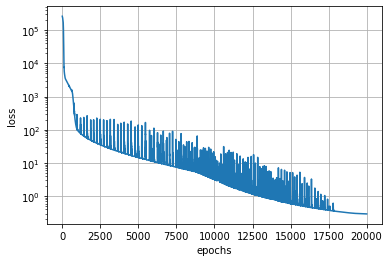

<Figure size 432x288 with 0 Axes>

In [101]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()
plt.savefig('loss.png')

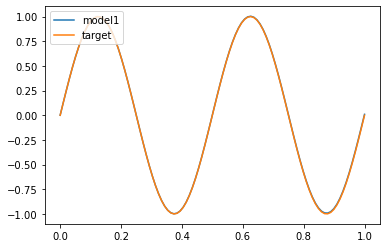

In [102]:
x = np.linspace(0,1,10)
discrete = np.linspace(0,1,100)
target = []

for i in range(100): 
    x_i = discrete[i]
    target.append(np.sin(4*np.pi * x_i)) 
    
#plt.plot(discrete,1 + discrete*model3([discrete]).numpy().T[0], label = 'model1')
plt.plot(discrete, model4([discrete]).numpy().T[0], label = 'model1')
plt.plot(discrete,target, label = 'target')
plt.legend(loc =  'upper left')

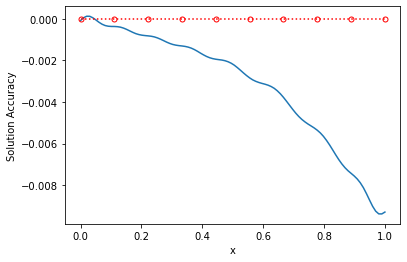

In [103]:
plt.plot(discrete,target-(model4([discrete]).numpy().T[0]))
plt.plot(discrete,[0]*100, ':r')
plt.plot(x,[0]*10, 'o', color = 'red', mfc = 'none', markersize = 5)
plt.ylabel('Solution Accuracy')
plt.xlabel('x')
plt.show()